In [12]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.colors as mcolors
from scipy.stats import bootstrap
import random as rd
from file_helper import load_all_files
from distutils.spawn import find_executable
from itertools import cycle
import os
import pickle as pk
from statistic.generate_statistics import genSstat, get_ranking_results, reject_if_bad_test
from plotting import plot_stat, put_plot_rank, get_color

In [14]:
path_dir = 'results'
base =6
power_base = base
list_files = load_all_files(path_dir)
file_to_load = 'GEN_'+str(base**base)+'_10000_10_2_3_binning'
print(file_to_load)
print(list_files)
for file in list_files:
    file_name = file.split('.')[0]
    if file_to_load in file_name:
        print('found')
        with open(os.path.join(path_dir, file), 'rb') as f:  # load the data
                data = pk.load(f)
                data = data['data']

GEN_46656_10000_10_2_3_binning
['GEN_46656_10000_10_2_3_ranking.pk', 'GEN_46656_10000_10_2_3_hypothesis_algo.pk', 'GEN_46656_10000_10_2_3_S_algo.pk', 'GEN_46656_10000_10_2_3_binning_algo.pk']
found


In [33]:
list_of_title_q = list(data.keys())
print(data[list_of_title_q[0]][0])
Bs = [len(p) for p['p'] in data[list_of_title_q[0][0]]]

m = 10000


store_results_algo = {}
store_results_random = {}
store_results_ranking = {'algo': [], 'random': []}
metrics = ['S', 'test', 'binning', 'A']
for metric in metrics:
    store_results_algo[metric] = {}
    store_results_random[metric] = {}
    for title in list_of_title_q:
        store_results_algo[metric][title] = []
        store_results_random[metric][title] = []

[{'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.37559999999999993, 0.1658000000000002, 0.007099999999999662]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.38080000000000025, 0.15470000000000014, 0.007699999999999263]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.37480000000000013, 0.16400000000000006, 0.008099999999999441]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.36929999999999996, 0.15680000000000022, 0.009199999999999542]}, {'p': [0.24999999999999972, 0.24999999999999925, 0], 'q': [0.25489999999999996, 0.28640000000000004, 0.009399999999999853]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.38520000000000026, 0.1611000000000001, 0.008499999999999175]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.3750000000000002, 0.15840000000000012, 0.008699999999999486]}, {'p': [0.3749999999999993, 0.12499999999999968, 0], 'q': [0.3813, 0.16500000000000006, 0.006099999999999772]}, {'p': [0.7499999999999

KeyError: 'F'

In [27]:
store_results_ranking

{'algo': [], 'random': []}

In [22]:
test_epsilon = 0.05
print(test_epsilon)
delta = 1/3
for b in range(4):  # For each bin granularity
    for i, q_name in enumerate(list_of_title_q):
        print(q_name)
        list_binned_algo = data[q_name][b]
        
        test_algo = [1-reject_if_bad_test(
                    trial['p'], trial['q'], m, epsilon=test_epsilon, delta=delta)[0] for trial in list_binned_algo]
        print(test_algo)
        A = [np.sqrt(reject_if_bad_test(
                    trial['p'], trial['q'], m, epsilon=test_epsilon, delta=delta)[1]) for trial in list_binned_algo]
        
        store_results_algo['test'][q_name].append(test_algo)
        store_results_algo['A'][q_name].append(A)

plot_data={'x': Bs, 'data': store_results_algo['test']}

0.05
FCDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
argmaxAR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
transformer
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
CNF
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ground truth
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FCDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
argmaxAR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
transformer
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CNF
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ground truth
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
FCDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
argmaxAR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
transformer
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CNF
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ground truth
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
FCDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
argmaxAR
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
transformer
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CNF
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CDM
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ground truth
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
list_of_title_q

['FCDM', 'argmaxAR', 'transformer', 'CNF', 'CDM', 'ground truth']

FCDM 0.1967443639990918 +/- 0.025
FCDM 0.20086553050113087 +/- 0.025
FCDM 0.2150504011516789 +/- 0.025
FCDM 0.21375838320210097 +/- 0.025
FCDM 0.1967443639990918 +/- 0.025
FCDM 0.20086553050113087 +/- 0.025
FCDM 0.2150504011516789 +/- 0.025
FCDM 0.21375838320210097 +/- 0.025
argmaxAR 0.27085349135566816 +/- 0.025
argmaxAR 0.27793485058703615 +/- 0.025
argmaxAR 0.28518515780906506 +/- 0.025
argmaxAR 0.27722394941320794 +/- 0.025
argmaxAR 0.27085349135566816 +/- 0.025
argmaxAR 0.27793485058703615 +/- 0.025
argmaxAR 0.28518515780906506 +/- 0.025
argmaxAR 0.27722394941320794 +/- 0.025
CNF 0.465315839260868 +/- 0.025
CNF 0.4482905703219984 +/- 0.025
CNF 0.44252166718341046 +/- 0.025
CNF 0.43131647544386686 +/- 0.025
CNF 0.465315839260868 +/- 0.025
CNF 0.4482905703219984 +/- 0.025
CNF 0.44252166718341046 +/- 0.025
CNF 0.43131647544386686 +/- 0.025
CDM 0.2746579271674759 +/- 0.025
CDM 0.2906778401211182 +/- 0.025
CDM 0.2936956742091648 +/- 0.025
CDM 0.29657829807527625 +/- 0.025
CDM 0.2746579

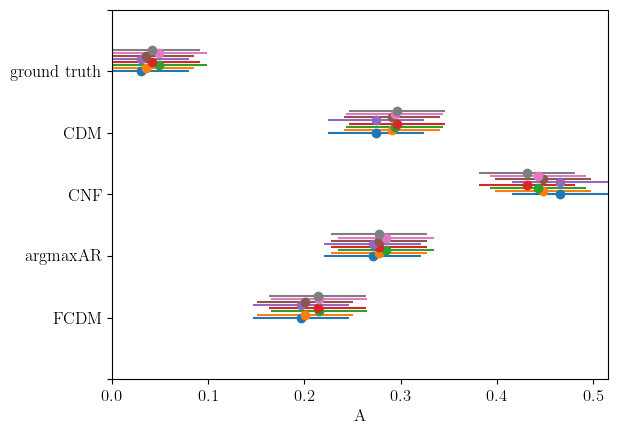

In [24]:
plt.close()
q_index = 1
max_val = 0
for q_name in list_of_title_q:
    if q_name != 'transformer':
        A_B_trials = store_results_algo['A'][q_name]
        for i, A_trials in enumerate(A_B_trials):


            print(q_name, np.mean(A_trials), '+/-', test_epsilon/2)
            x = [np.mean(A_trials)]
            y = [q_index+i*0.05]
            errors = [test_epsilon]
            plt.errorbar(x, y, xerr=errors, fmt = 'o', color=get_color(i))
            upper = np.mean(A_trials) + test_epsilon
            if upper > max_val:
                max_val = upper
        q_index+=1

trimed_list_index = [q_name for q_name in list_of_title_q if q_name!='transformer']

y_positions = [i for i in range(q_index+1)]
plt.yticks(y_positions, ['']+trimed_list_index+['']) 
plt.xlim((0,max_val))
plt.xlabel('A')
plt.show()
# plt.savefig(file_to_load+'A.pdf')
plt.close()

In [12]:
plot_data['data']

{'no temper (uniform)': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'slightly tempered': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'medium tempered': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'heavily tempered': [[1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 0, 1, 1, 0, 0, 0, 0, 1, 1],
  [1, 0, 0, 1, 1, 0, 0, 0, 1, 

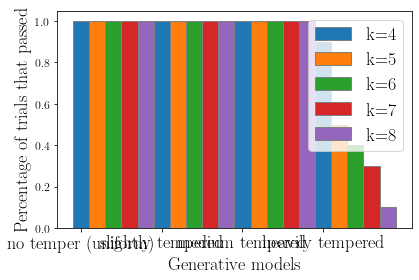

In [13]:
plt.close()
put_plot_rank(None, plot_data['x'], plot_data['data'])
#plot_stat(os.path.join('figures',str(test_epsilon)+file_name+'.pdf'), 'Bins' , 'algo')
plt.show()
# plt.close()

In [5]:

import math
import os
from tqdm import tqdm
from sampling.discrete import makeUniProbArr, prob_array_to_dict
from file_helper import create_prefix_from_list, load_samples, store_for_plotting
from sampling.loading_samples import load_generative_model_samples
from sampling.stair import make_stair_prob
from statistic.binning_algo import binning_on_samples
import numpy as np
import random
from statistic.generate_statistics import genSstat, get_ranking_results, reject_if_bad_test

np.random.seed(3)
random.seed(3)
experiment = "GEN"  # either SYNTH or GEN
test_epsilon = 0.20
delta = 0.05
compute_random = False
if experiment == "SYNTH":  # if we generate q ourselves
    print('You are running the synthetic experiment...')

    power_base = 6
    list_U = [power_base**power_base]
    list_M = [10000]
    init_e = 0.1
    init_b = 30
    trials = 2
    S = 3
    ratio = 2
    distribution_type = 'STAIRS'  # STAIRS

    #list_of_espilon_q = [0, init_e, init_e*1.5, init_e*2]
    list_of_espilon_q = [0]
    # list_of_title_q = [
    #     'no temper (uniform)', 'slightly tempered', 'medium tempered', 'heavily tempered']
    list_of_title_q = ['no temper (uniform)']
else:  # if we take q as the generative models we have, we load the samples.
    print('You are running the generative model experiment...')
    power_base = 6
    list_U = [power_base**power_base]
    list_M = [10000]
    S = 2
    ratio = 3
    trials = 10

Bs = list(range(S+1, 2*(S+1)+1))
list_of_binning_algo = ['algo', 'random']

m = list_M[0]
print("for this round m is ", m)
U = list_U[0] 
print("and U is ", U)
prefix = create_prefix_from_list([experiment, U, m, trials, S, ratio])
if experiment == "SYNTH":
    if distribution_type == 'UNIFORM':
        ground_truth_p = prob_array_to_dict(makeUniProbArr(U))

    elif distribution_type == 'STAIRS':
        ground_truth_p = make_stair_prob(
            U, posU=(math.factorial(power_base)/U), ratio=ratio,  S=S)

    else:
        raise NotImplemented
    list_of_samples = load_samples(
        list_of_espilon_q, init_b, ground_truth_p, trials, U, m, S, ratio)
else:
    dict_of_samples, ground_truth_p = load_generative_model_samples(
        power_base, num_files=trials, m=10000, using_max=True)
    list_of_samples = [val for _, val in dict_of_samples.items()]
    list_of_title_q = [key for key, _ in dict_of_samples.items()]

You are running the generative model experiment...
for this round m is  10000
and U is  46656
should_be_one 1.000000000000002
should_be_one 1.0000000000000022
should_be_one 1.000000000000002
should_be_one 1.000000000000002
should_be_one 1.000000000000002


In [6]:
print(len(list_of_samples))
print(list_of_title_q)

6
['FCDM', 'argmaxAR', 'transformer', 'CNF', 'CDM', 'ground truth']


In [9]:
C = int(math.factorial(power_base)/2)
# for i in range(len(list_of_samples)):
#     samples_of_model = list_of_samples[i]
#     first_trial_of_model = samples_of_model[0]
    
#     xs = list(first_trial_of_model.keys())
#     ys= list(first_trial_of_model.values())

#     plt.plot(xs, ys, 'o', label=list_of_title_q[i])
# plt.legend()
# plt.show()
# plt.close()


for i in range(len(list_of_samples)-1):
    if i !=list_of_title_q.index('transformer'):
        samples_of_model = list_of_samples[i]
        first_trial_of_model = samples_of_model[0]

        xs = list(first_trial_of_model.keys())
        ys= list(first_trial_of_model.values())

        only_pos_x = [x for x in xs if x< math.factorial(power_base)]
        only_pos_y = [ys[i] for i in range(len(ys)) if xs[i]< math.factorial(power_base)]

        
        plt.plot(only_pos_x, only_pos_y, 'o', markersize=1,label=list_of_title_q[i])
gt_x1 = list(range(C))
gt_y1 = [3/(2*math.factorial(power_base)) for _ in gt_x1]


gt_y2 = [1/(2*math.factorial(power_base)) for _ in gt_x1]

plt.plot(range(C*2), gt_y1+gt_y2,label='ground truth')
plt.legend()
plt.ylabel('p(x)')
plt.xlabel('x')
plt.savefig('unsorted.pdf')
plt.close()

In [10]:
C = int(math.factorial(power_base)/2)
for i in range(len(list_of_samples)-1):
    if i !=list_of_title_q.index('transformer'):
        samples_of_model = list_of_samples[i]
        first_trial_of_model = samples_of_model[0]

        xs = list(first_trial_of_model.keys())
        ys= list(first_trial_of_model.values())
        print(np.sum(ys))
        only_pos_x_1 = [x for x in xs if x< math.factorial(power_base)/2]
        only_pos_y_1 = [ys[i] for i in range(len(ys)) if xs[i]< math.factorial(power_base)/2]
        sorting_1 = np.argsort(only_pos_y_1)
        only_pos_y_1 = np.array(only_pos_y_1)[sorting_1]
        only_pos_x_1.sort()
        only_pos_y_1 = list(only_pos_y_1)
        only_pos_y_1.reverse()

        only_pos_x_2 = [x for x in xs if (x< math.factorial(power_base) and x>= math.factorial(power_base)/2)]
        only_pos_y_2 = [ys[i] for i in range(len(ys)) if (xs[i]< math.factorial(power_base)and xs[i]>= math.factorial(power_base)/2)]
        sorting_2 = np.argsort(only_pos_y_2)
        only_pos_y_2 = np.array(only_pos_y_2)[sorting_2]
        only_pos_x_2.sort()
        only_pos_y_2 = list(only_pos_y_2)
        only_pos_y_2.reverse()
        # add zeros where needed
        both_x = list(range(2*C))
        if C-len(only_pos_y_1)>0:
            zeros_1 = [0 for _ in range(C-len(only_pos_y_1))]
            only_pos_y_1 = zeros_1+only_pos_y_1
        if    C-len(only_pos_y_2)>0:      
            zeros_2 = [0 for _ in range(C-len(only_pos_y_2))]
            only_pos_y_2 = zeros_2+only_pos_y_2

        both_y = list(only_pos_y_1)+list(only_pos_y_2)


        plt.plot(both_x, both_y, linewidth=1, label=list_of_title_q[i])
    
#     only_zero_x = [x for x in xs if x>= math.factorial(power_base)/2]
#     only_zero_y = [ys[i] for i in range(len(ys)) if xs[i]>= math.factorial(power_base)/2]
#     print(np.sum(only_zero_y))
gt_x1 = list(range(C))
gt_y1 = [3/(2*math.factorial(power_base)) for _ in gt_x1]


gt_y2 = [1/(2*math.factorial(power_base)) for _ in gt_x1]

plt.plot(range(C*2), gt_y1+gt_y2,label='ground truth')
plt.ylabel('p(x)')
plt.xlabel('x')  
plt.legend()
plt.savefig('sorted.pdf')
plt.close()

1.000000000000002
1.000000000000002
1.000000000000002
1.000000000000002


In [11]:
C = int(math.factorial(power_base)/2)
for i in range(len(list_of_samples)-1):
    if i !=list_of_title_q.index('transformer'):
        samples_of_model = list_of_samples[i]
        first_trial_of_model = samples_of_model[0]

        xs = list(first_trial_of_model.keys())
        ys= list(first_trial_of_model.values())


        only_pos_y_1 = [ys[i] for i in range(len(ys)) if xs[i]< math.factorial(power_base)/2]




        only_pos_y_2 = [ys[i] for i in range(len(ys)) if (xs[i]< math.factorial(power_base)and xs[i]>= math.factorial(power_base)/2)]




        only_zero_y = [ys[i] for i in range(len(ys)) if xs[i]>= math.factorial(power_base)]
        print(list_of_title_q[i])
        print(np.sum(only_zero_y))
        both_x = [1,1.99,2,2.99,3,3.99]
        p_1 = np.sum(only_pos_y_1)
        p_2 = np.sum(only_pos_y_2)
        p_3 = np.sum(only_zero_y)
        both_y = [p_1,p_1, p_2,p_2,p_3,p_3 ]
        plt.plot(both_x, both_y,label=list_of_title_q[i])
    

plt.plot([1,1.99,2,2.99,3,3.99], [0.75, 0.75,0.25,0.25,0,0],label='ground truth')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.xticks([])
plt.legend()
plt.savefig('bin.pdf')
plt.close()

FCDM
0.008050000000000002
argmaxAR
0.06321000000000003
CNF
0.05056000000000001
CDM
0.04666


In [29]:
import itertools
import math
def get_type(comb):
    choices = {}
    for x in comb:
        if x not in choices:
            choices[x] = 1
        else:
            return 'not a permutation'
    if comb[0] < comb[-1]:
        return 'likely'
    else:
        return 'rare'

def get_converting_dict(base):
    converting_dict = {}
    x = []
    y = []
    i = 0
    for comb in itertools.product(range(base), repeat=base):
        comb_type = get_type(comb)
        if comb_type == 'likely':
            y.append(3/(2*(math.factorial(base))))
        elif comb_type == 'rare':
            y.append(1/(2*(math.factorial(base))))
        else:
            y.append(0)
        x.append(i)
        i+=1
    return x,y

In [30]:
x,y = get_converting_dict(6)

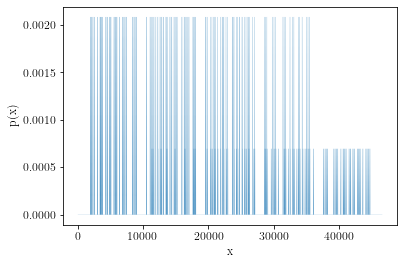

In [31]:
plt.plot(x,y,linewidth=0.1)
plt.ylabel('p(x)')
plt.xlabel('x')
plt.savefig('p.pdf')